# Full Workflow {.unnumbered}

## Packages

In [21]:
import sys
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rio

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('scripts')))

# from scripts.config import *
from scripts.utils import create_cube_subset, create_paths
from scripts.load_aux_data_01 import load_aux_data
from scripts.cube_preprocessing_02 import cube_preprocess
from scripts.base_analysis_03 import base_analysis, change_plot, plot_timeseries
from scripts.config import variables
import matplotlib.pyplot as plt

# Write data to disk set to False
write_data = False


## Setup

First we setup the data path and use create_paths() from utils to create paths necessary throughout the analysis.

Second we use create_subset() to create a subset of the Earth System Data Cube, croped to:

- our AOI, the extent of germany 
- the time span where the SIF variable is avaialble 
- to the relevant variables

[More Information](#sec-utils)

In [25]:
# Create a data directory
data_path = "data"
os.makedirs(data_path, exist_ok=True)

# Create paths to the data
germany_shp_path, corine_file_path, cube_sample_path, cube_crop_path, cube_crop_mask_path = create_paths(data_path=data_path)

# Create a subset of the Earth System Data Cube, containing only relevant variables and the desired spatial and temporal extent
cube_subset = create_cube_subset()

print(cube_subset)

<xarray.Dataset> Size: 30MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
    spatial_ref             int64 8B 0
Data variables:
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4

## Downloading auxillary data

The first part of the analysis is to download and preprocess all the necassaty auxillary data:

- download german border shapefile
- download and preprocess Corine data (for the forest mask) and use the border data to define the AOI
- create sif sample tif for spatial resolution and transform (used later to resample corine data)

[More Information](#sec-load_aux)

In [22]:
# Download auxiliary data (Germany border, Corine landcover data, sample tif)
load_aux_data(data_path, cube_subset, download = write_data)

# Load the germany border shapefile
germany_gpd = gpd.read_file(germany_shp_path)


----------------------------------------------------------------------------------------------------
Processing Corine data...
----------------------------------------------------------------------------------------------------
Sample path created at: data/cubes/cube_sif_sample.tif
----------------------------------------------------------------------------------------------------


## Preprocessing the cube 

Next we want to preprocess our data cube. 

This includes:
- croping the cube with the german border shape
 
- masking the cube with the corine forest cover:
   
  - Calculate the forest percentage of the Corine landcover data over the cube grid
  - add the forest percentages to the cube
  - add a binary forest cover layer to the cube (0 for <50% forest cover, 1 for >=50% forest cover)
  - use the layer to mask the cube

[More Information](#sec-cube_preproc)

In [4]:

# Crop the cube to the extent of Germany and mask it with the Corine landcover data (50% forest cover)
cube_subset_crop, cube_subset_crop_mask = cube_preprocess(
        cube_subset, germany_gpd, corine_file_path, cube_sample_path, 
        out_path_crop=cube_crop_path, out_path_mask=cube_crop_mask_path, 
        all_touched=True, write=write_data
    )
    
# Calculate the temporal changes in the variables 
summer_sif_mean_cube, summer_mean_to_2017, changes = base_analysis(cube_subset_crop, years=[2018, 2019])




Preprocessing cube
Clipping cube to Germany border
Calculate forest cover percentage over cube grid


In [6]:
summer_sif_mean_cube

<xarray.DataArray 'sif_gosif' (year: 20, lat: 31, lon: 37)> Size: 92kB
dask.array<stack, shape=(20, 31, 37), dtype=float32, chunksize=(1, 31, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 248B 47.38 47.62 47.88 ... 54.38 54.62 54.88
  * lon          (lon) float64 296B 5.875 6.125 6.375 ... 14.38 14.62 14.88
    spatial_ref  int64 8B 0
  * year         (year) int64 160B 2002 2003 2004 2005 ... 2018 2019 2020 2021
Attributes: (12/25)
    acknowledgment:             https://doi.org/10.3390/rs11050517
    date_modified:              2022-10-11 22:20:05.841847
    description:                GOSIF Solar-Induced Chlorophyll Fluorescence ...
    geospatial_lat_max:         89.87499999999999
    geospatial_lat_min:         -89.87500000000001
    geospatial_lat_resolution:  0.25
    ...                         ...
    standard_name:              sif
    temporal_resolution:        8D
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        2000-03-01T00:00:00.000000000
    time_period:                8D
    units:                      W m^-2 sr^-1 um^-1

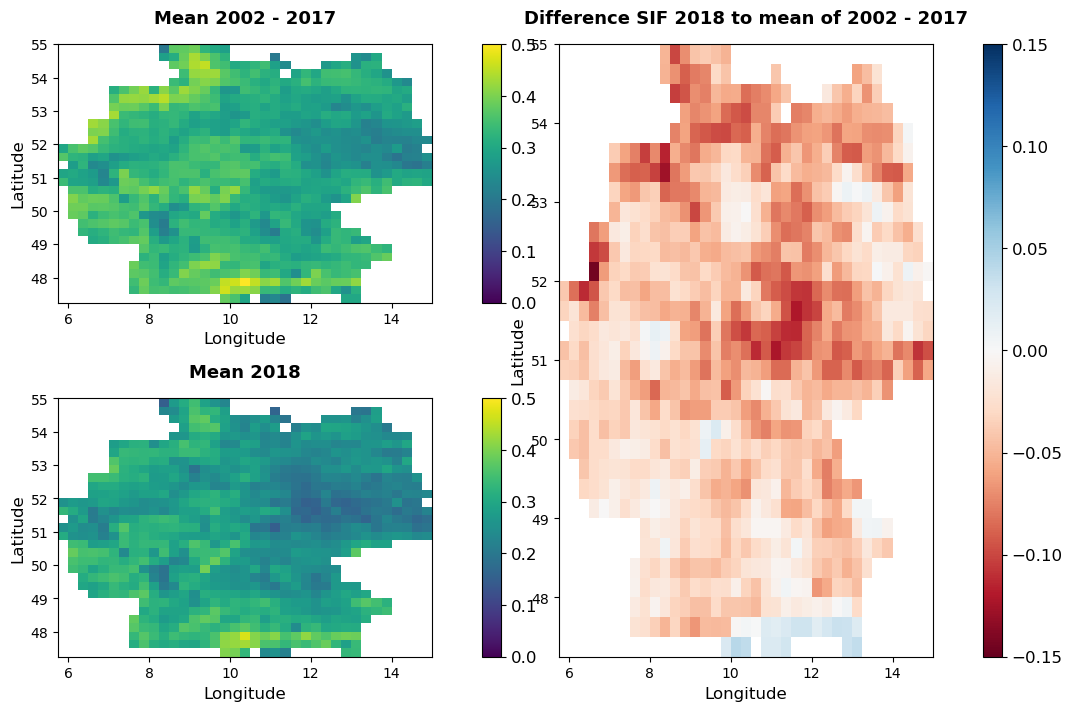

In [26]:
change_plot(ref_period = summer_mean_to_2017, data_2018 = summer_sif_mean_cube.sel(year=2018), changes = changes);